In [ ]:
#@title GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
#@title Imports and Notebook Utilities
# The notebook contains utility functions from Mordvinstev et al.'s colab notebook.
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

In [ ]:
#@title Custom Target Creation {vertical-output: true}
GRID_SIZE = 80
def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def create_square(size, grid_size):
  grid = np.zeros((1,grid_size, grid_size, 4), np.float32)
  start = grid_size//2 - size//2
  end = grid_size//2 + size//2
  grid[:,start:end, start:end,:3] = 0 # black
  grid[:,start:end, start:end,3:] = 1 # alpha = grown
  # padding
  # grid[]
  return grid
target = create_square(40, GRID_SIZE)
# target[...,:3]*=target[...,3:]
imshow(zoom(target[0][...,3]))
imshow(zoom(to_rgb(target[0])))


In [ ]:
#@title  Emoji Target Creation {vertical-output: true} 
TARGET_EMOJI = "🦎" #@param {type:"string"}
TARGET_SIZE = 40

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return imread(url, TARGET_SIZE)

target = load_emoji(TARGET_EMOJI)
target[...,:3]*= target[...,3:]
imshow(zoom(target))


In [ ]:
#@title Neural CA model
from tensorflow.keras.layers import Conv2D

def get_living_mask(x):
  alpha = x[...,3:4]
  return tf.cast(tf.nn.max_pool2d(alpha,3,1,'SAME') >=0.3,tf.float32)
class CA(tf.Module):
  def __init__(self, kernel_init=True):
    if (kernel_init):
        # Kernel initializer to zero weights added to make default do nothing behavior
        self.model = tf.keras.Sequential([
            Conv2D(128,3,padding='same',activation=tf.nn.relu),
            Conv2D(CHANNEL_N, 1, kernel_initializer=tf.zeros) 
        ])
    else:
        self.model = tf.keras.Sequential([
            Conv2D(128,3,padding='same',activation=tf.nn.relu),
            Conv2D(CHANNEL_N, 1) #
        ])
    # remove kernel initializer to see evolution of CA from initial seed
  @tf.function
  def __call__(self,x):
    # alive_masking
    alive_mask = get_living_mask(x)
    # stochastic update
    p = 0.5 # probability of being 0
    update_mask = tf.floor(tf.random.uniform(x[...,:1].shape) + p)
    x = x + self.model(x)*update_mask
    x*= alive_mask
    return x


In [ ]:
#@title test CA do nothing behavior {vertical-output: true}
CHANNEL_N = 16
GRID_SIZE = 80
def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x  
def run_ca(ca, x, iter_n = 100):
  with VideoWriter() as vid:
    for i in range(iter_n):
      vid.add(zoom(to_rgb(x[0])))
      x = ca(x)
seed = make_seed(TARGET_SIZE)
do_nothing = True
ca = CA(do_nothing)
run_ca(ca, seed, 300)

In [ ]:
#@title Trainer Class 
class Trainer():
    def __init__(self, ca, optimizer):
        self.optimizer = optimizer
        self.ca = ca
    def get_trained_ca(self):
        return self.ca
    
    @tf.function
    def train(self, seed, num_ca_steps, target, 
              batch_size = 1, normalize_grads = True, adaptive_loss=True):
        with tf.GradientTape() as g:
            if (batch_size > 1):
                x = tf.repeat(seed, batch_size, 0)
            else:
                x = seed
            for i in range(num_ca_steps):
                x = self.ca(x)
            target_loss = tf.reduce_mean(tf.square(x[...,:4] - target))
            if adaptive_loss:
                diff_loss = 0.0
                for i in tf.range(50):
                    prev_x = x
                    x = self.ca(x)
                    diff_loss += tf.reduce_mean(tf.square(x-prev_x))
                loss = target_loss + diff_loss
            else:
                loss = target_loss
        params = ca.trainable_variables
        grads = g.gradient(loss,params)
        if normalize_grads:
            grad_norm = tf.add_n([tf.reduce_sum(g*g) for g in grads])**0.5
        self.optimizer.apply_gradients(zip(grads,params))
        return loss,x

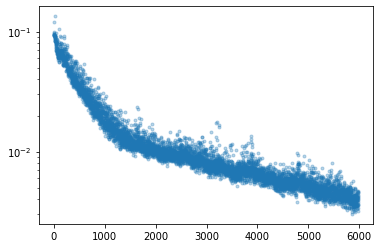

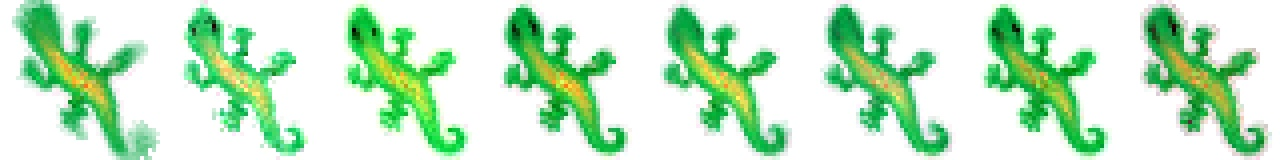

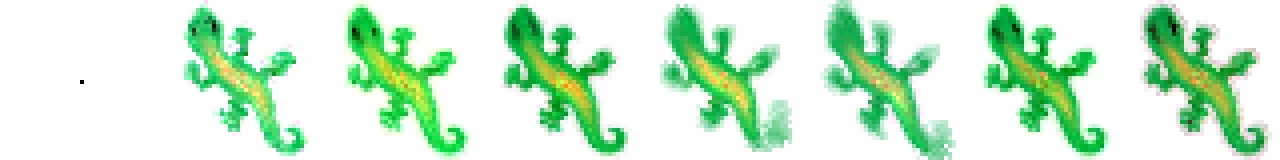

5980 0.004580608


In [ ]:
#@title Training test {vertical-output: true}
ca = CA(True)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000],[1e-3, 3e-4])
optimizer = tf.optimizers.Adam(lr)
seed = make_seed(TARGET_SIZE)
trainer = Trainer(ca, optimizer)
num_epochs = 6000
num_ca_steps = 50
batch_size = 4
train_from_ca_output = True
pool_batch_size = 8
pool_size = 256
normalize_grads = True
if (train_from_ca_output):
    adaptive_loss = False
    batch_size = 1
else:
    adaptive_loss = True
loss_log = []

# select target
SQUARE_SIZE=20
# target = create_square(SQUARE_SIZE, TARGET_SIZE)
target = load_emoji(TARGET_EMOJI)
target[...,:3]*= target[...,3:]
if train_from_ca_output:
    pool = np.repeat(seed, pool_size, 0)
for i in range(num_epochs):
    if train_from_ca_output:
        batch_idx = np.random.choice(len(pool), pool_batch_size, replace=False)
        x0 = pool[batch_idx]
        x0[:1]= seed
        loss,x = trainer.train(x0,num_ca_steps,target, batch_size, 
                           normalize_grads, adaptive_loss)
        pool[batch_idx] = x
        loss_log.append(loss.numpy())
    else:
        x0 = seed
        loss,x = trainer.train(x0,num_ca_steps,target, batch_size, 
                            normalize_grads, adaptive_loss)
        loss_log.append(loss.numpy())
    if i%20==0:
        clear_output(True)
        pl.plot(loss_log,'.', alpha=0.3)
        pl.yscale('log')
        pl.show()
        if (train_from_ca_output):
            viz = np.hstack(to_rgb(x))
            imshow(zoom(viz))
            imshow(zoom(np.hstack(to_rgb(x0))))
        else:
            imshow(zoom(to_rgb(x[0])))
        print(i, loss.numpy(),flush=True)


In [ ]:
ca_steps = 1000
run_ca(ca, seed, ca_steps)

In [ ]:
# Larger grid
x = np.zeros([1,80,800,CHANNEL_N],np.float32)
x[:,40,40,3:] = 1.0
run_ca(ca, x, ca_steps)